# MIT-BIH Supraventricular Arrhythmia Database (_svdb_)

Part of the ECG Database Collection:

| Short Name | Long Name |
| :--- | :--- |
| _mitdb_ | MIT-BIH Arrhythmia Database |
| _svdb_ | MIT-BIH Supraventricular Arrhythmia Database |
| _ltdb_ | MIT-BIH Long-Term ECG Database |

[Docu](https://wfdb.readthedocs.io/en/latest) of the `wfdb`-package.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import wfdb
import os
from typing import Final
from collections.abc import Callable
from config import data_raw_folder, data_processed_folder
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

In [2]:
dataset_collection_name = "SVDB"
source_folder = os.path.join(data_raw_folder, "MIT-BIH Supraventricular Arrhythmia Database")
target_folder = data_processed_folder

Metadata handling

In [3]:
# type
DatasetMetadataRecord = {
    "dataset_name": str,
    "collection_name": str,
    "train_path": str,
    "test_path": str,
    "dataset_type": str,
    "datetime_index": bool,
    "split_at": int,
    "train_type": str,
    "train_is_normal": bool,
    "input_type": str,
    "length": int
}

class DatasetMetadata:
    """
    ATTENTION: Not thread-safe! There is no check for changes to the underlying `dataset.csv` file while this class is loaded.
    """
    
    FILENAME: Final[str] = "datasets.csv"
    
    _filepath: str
    _df: pd.DataFrame
    _dirty: bool

    def __init__(self, target_folder: str):
        self._filepath = os.path.join(target_folder, self.FILENAME)
        self._dirty = False
        if not os.path.isfile(self._filepath):
            self._df = self._create_metadata_file()
        else:
            self.refresh(force = True)
    
    def __enter__(self) -> 'DatasetMetadata':
        return self
    
    def __exit__(self, exception_type, exception_value, exception_traceback) -> 'DatasetMetadata':
        self.save()
        return self
    
    def __repr__(self) -> str:
        return repr(self._df)
    
    def __str__(self) -> str:
        return str(self._df)
        
    def _create_metadata_file(self) -> pd.DataFrame:
        df_temp = pd.DataFrame(columns=["dataset_name", "collection_name", "train_path", "test_path", "dataset_type", "datetime_index", "split_at", "train_type", "train_is_normal", "input_type", "length"])
        df_temp.set_index(["dataset_name", "collection_name"], inplace=True)
        df_temp.to_csv(self._filepath)
        return df_temp
    
    def add_dataset(self,
        dataset_name: str,
        collection_name: str,
        train_path: str,
        test_path: str,
        dataset_type: str,
        datetime_index: bool,
        split_at: int,
        train_type: str,
        train_is_normal: bool,
        input_type: str,
        dataset_length: int
    ) -> 'DatasetMetadata':
        df_new = pd.DataFrame({
            "train_path": train_path,
            "test_path": test_path,
            "dataset_type": dataset_type,
            "datetime_index": datetime_index,
            "split_at": split_at,
            "train_type": train_type,
            "train_is_normal": train_is_normal,
            "input_type": input_type,
            "length": dataset_length
        }, index=[(dataset_name, dataset_collection_name)])
        df = pd.concat([self._df, df_new], axis=0)
        df = df[~df.index.duplicated(keep = "last")]
        self._df = df
        self._dirty = True
        return self
    
    def add_datasets(self, datasets: list[DatasetMetadataRecord]) -> 'DatasetMetadata':
        df_new = pd.DataFrame(datasets)
        df_new.set_index(["dataset_name", "collection_name"], inplace = True)
        df = pd.concat([self._df, df_new], axis=0)
        df = df[~df.index.duplicated(keep = "last")]
        self._df = df
        self._dirty = True
        return self
    
    def refresh(self, force: bool = False) -> None:
        if not force and self._dirty:
            raise Exception("There are unsaved changes in memory that would get lost by reading from disk again!")
        else:
            self._df = pd.read_csv(self._filepath, index_col=["dataset_name", "collection_name"])
    
    def save(self) -> None:
        self._df.to_csv(self._filepath)
        self._dirty = False

In [4]:
def load_dataset_names() -> list[str]:
    with open(os.path.join(source_folder, "RECORDS"), 'r') as f:
        records = [l.rstrip('\n') for l in f]
    return records

In [5]:
def transform_and_label(source_file: str, target: str) -> int:
    print(f"Transforming {os.path.basename(source_file)}")
    # load dataset
    record = wfdb.rdrecord(source_file)
    df_record = pd.DataFrame(record.p_signal, columns=record.sig_name)
    print(f"  record {record.file_name[0]} loaded")

    # load annotation file
    atr = wfdb.rdann(source_file, "atr")
    assert record.fs == atr.fs, "Sample frequency of records and annotations does not match!"
    df_annotation = pd.DataFrame(atr.symbol, index=atr.sample, columns=["Label"])
    df_annotation = df_annotation.reset_index()
    df_annotation.columns = ["position", "label"]
    print(f"  {atr.ann_len} beat annotations for {source_file} loaded")

    # calculate normal beat length
    print("  preparing windows for labeling...")
    df_normal_beat = df_annotation.copy()
    df_normal_beat["prev_position"] = df_annotation["position"].shift()
    df_normal_beat["prev_label"] = df_annotation["label"].shift()
    df_normal_beat = df_normal_beat[(df_normal_beat["label"] == "N") & (df_normal_beat["prev_label"] == "N")]
    s_normal_beat_lengths = df_normal_beat["position"] - df_normal_beat["prev_position"]
    print(f"    normal beat distance samples = {len(s_normal_beat_lengths)}")
    normal_beat_length = s_normal_beat_lengths.median()
    if (normal_beat_length % 2) == 0:
        normal_beat_length += 1
    beat_window_size = int(normal_beat_length)
    beat_window_margin = (beat_window_size - 1)//2
    print(f"    window size = {beat_window_size}")
    print(f"    window margins (left and right) = {beat_window_margin}")

    # calculate beat windows
    ## for external anomalies
    df_ext = df_annotation[(df_annotation["label"] == "|") | (df_annotation["label"] == "Q")].copy()
    df_ext["window_start"] = df_ext["position"]-beat_window_margin
    df_ext["window_end"] = df_ext["position"]+beat_window_margin
    df_ext = df_ext[["position", "window_start", "window_end"]]
    print(f"    {len(df_ext)} windows for external anomalies")
    ## for anomalous beats
    df_svf = df_annotation[(df_annotation["label"] != "|") & (df_annotation["label"] != "~") & (df_annotation["label"] != "+")].copy()
    df_svf["position_next"] = df_svf["position"].shift(-1)
    df_svf["position_prev"] = df_svf["position"].shift(1)
    #df_svf = df_svf[(df_svf["position_prev"].notnull()) & (df_svf["position_next"].notnull())]
    df_svf = df_svf[(df_svf["label"] != "Q") & (df_svf["label"] != "N")]
    df_svf["window_start"] = np.minimum(df_svf["position"].values-beat_window_margin, df_svf["position_prev"].values+beat_window_margin)
    df_svf["window_end"] = np.maximum(df_svf["position"].values+beat_window_margin, df_svf["position_next"].values-beat_window_margin)
    df_svf = df_svf[["position", "window_start", "window_end"]]
    print(f"    {len(df_svf)} windows for anomalous beats")
    ## merge
    df_windows = pd.concat([df_ext, df_svf])
    print(f"  ...done.")

    # add labels based on anomaly windows
    print("  labeling")
    df_record["is_anomaly"] = 0
    for _, (_, t1, t2) in df_windows.iterrows():
        tmp = df_record[df_record.index >= t1]
        tmp = tmp[tmp.index <= t2]
        df_record["is_anomaly"].values[tmp.index] = 1

    # reconstruct timestamps and set as index
    print("  reconstructing timestamps")
    df_record["timestamp"] = pd.to_datetime(df_record.index.values * 1e+9/record.fs, unit='ns')
    df_record = df_record.set_index("timestamp")
    df_record.to_csv(target)
    print(f"Dataset {os.path.basename(source_file)} transformed and saved!")
    
    # return dataset length
    return record.sig_len

In [31]:
# shared by all datasets
dataset_type = "real"
input_type = "multivariate"
datetime_index = True
train_type = "unsupervised"
train_is_normal = False

dm = DatasetMetadata(target_folder)

# create target directory
dataset_subfolder = os.path.join(target_folder, input_type, dataset_collection_name)
try:
    os.makedirs(dataset_subfolder)
    print(f"Created directories {dataset_subfolder}")
except FileExistsError:
    print(f"Directories {dataset_subfolder} already exist")
    pass

Directories data-processed/multivariate/SVDB already exist


In [32]:
# dataset transformation
transform_file: Callable[[str, str], int] = transform_and_label

for dataset_name in load_dataset_names():
    # intentionally no file suffix (.dat)
    source_file = os.path.join(source_folder, dataset_name)
    filename = f"{dataset_name}.test.csv"
    path = os.path.join(dataset_subfolder, filename)
            
    # transform file and label it
    dataset_length = transform_file(source_file, path)
    print(f"Processed source dataset {source_file} -> {path}")

    # save metadata
    dm.add_dataset(
        dataset_name = dataset_name,
        collection_name = dataset_collection_name,
        train_path = None,
        test_path = path,
        dataset_type = dataset_type,
        datetime_index = datetime_index,
        split_at = None,
        train_type = train_type,
        train_is_normal = train_is_normal,
        input_type = input_type,
        dataset_length = dataset_length
    )

# save metadata of benchmark
dm.save()

Transforming 800
  record 800.dat loaded
  1921 beat annotations for data-raw/MIT-BIH Supraventricular Arrhythmia Database/800 loaded
  preparing windows for labeling...
    normal beat distance samples = 1772
    window size = 119
    window margins (left and right) = 59
    10 windows for external anomalies
    37 windows for anomalous beats
  ...done.
  labeling
  reconstructing timestamps
Dataset 800 transformed and saved!
Processed source dataset data-raw/MIT-BIH Supraventricular Arrhythmia Database/800 -> data-processed/multivariate/SVDB/800.test.csv
Transforming 801
  record 801.dat loaded
  2577 beat annotations for data-raw/MIT-BIH Supraventricular Arrhythmia Database/801 loaded
  preparing windows for labeling...
    normal beat distance samples = 1830
    window size = 97
    window margins (left and right) = 48
    0 windows for external anomalies
    334 windows for anomalous beats
  ...done.
  labeling
  reconstructing timestamps
Dataset 801 transformed and saved!
Process

In [33]:
dm.refresh()
dm._df

,,train_path,test_path,type,datetime_index,split_at,train_type,train_is_normal,input_type,length
dataset_name,collection_name,,,,,,,,,
A1Benchmark-6,WebscopeS5,NaN,data-processed/univariate/WebscopeS5/A1Benchma...,real,True,NaN,unsupervised,False,univariate,1439
A1Benchmark-3,WebscopeS5,NaN,data-processed/univariate/WebscopeS5/A1Benchma...,real,True,NaN,unsupervised,False,univariate,1461
A1Benchmark-40,WebscopeS5,NaN,data-processed/univariate/WebscopeS5/A1Benchma...,real,True,NaN,unsupervised,False,univariate,1427
A1Benchmark-20,WebscopeS5,NaN,data-processed/univariate/WebscopeS5/A1Benchma...,real,True,NaN,unsupervised,False,univariate,1422
A1Benchmark-4,WebscopeS5,NaN,data-processed/univariate/WebscopeS5/A1Benchma...,real,True,NaN,unsupervised,False,univariate,1423
...,...,...,...,...,...,...,...,...,...,...
890,SVDB,NaN,data-processed/multivariate/SVDB/890.test.csv,real,True,NaN,unsupervised,False,multivariate,230400
891,SVDB,NaN,data-processed/multivariate/SVDB/891.test.csv,real,True,NaN,unsupervised,False,multivariate,230400
892,SVDB,NaN,data-processed/multivariate/SVDB/892.test.csv,real,True,NaN,unsupervised,False,multivariate,230400


## Dataset transformation walk-through

In [9]:
def print_obj_attr(obj, name="Object"):
    print(name)
    tmp = vars(obj)
    for key in tmp:
        print(key, tmp[key])
    print("")
records = load_dataset_names()

### Load and parse dataset

In [10]:
# dataset
record = wfdb.rdrecord(os.path.join(source_folder, records[51]))
#print_obj_attr(record, "Record object")

df_record = pd.DataFrame(record.p_signal, columns=record.sig_name)
df_record

,ECG1,ECG2
0,-0.75,0.26
1,-0.71,0.31
2,-0.81,0.26
3,-0.70,0.37
4,-0.83,0.33
...,...,...
230395,-0.86,0.29
230396,-0.93,0.29
230397,-1.00,0.34
230398,-1.06,0.38


Add timestamp information based on sample interval ($$[fs] = samples/second$$):

In [11]:
display(Latex(f"Samples per second: $$fs = {record.fs} \\frac{{1}}{{s}}$$"))
display(Markdown(f"This gives a sample interval of {1e+9/record.fs} nanoseconds"))
df_record["timestamp"] = pd.to_datetime(df_record.index.values * 1e+9/record.fs, unit='ns')
df_record

<IPython.core.display.Latex object>

This gives a sample interval of 7812500.0 nanoseconds

,ECG1,ECG2,timestamp
0,-0.75,0.26,1970-01-01 00:00:00.000000000
1,-0.71,0.31,1970-01-01 00:00:00.007812500
2,-0.81,0.26,1970-01-01 00:00:00.015625000
3,-0.70,0.37,1970-01-01 00:00:00.023437500
4,-0.83,0.33,1970-01-01 00:00:00.031250000
...,...,...,...
230395,-0.86,0.29,1970-01-01 00:29:59.960937500
230396,-0.93,0.29,1970-01-01 00:29:59.968750000
230397,-1.00,0.34,1970-01-01 00:29:59.976562500
230398,-1.06,0.38,1970-01-01 00:29:59.984375000


In [12]:
# find all annotations
records = load_dataset_names()
annotations = {}
for r in records:
    atr = wfdb.rdann(os.path.join(source_folder, r), "atr")
    df_annotation = pd.DataFrame(atr.symbol, index=atr.sample, columns=["Label"])
    for an in df_annotation["Label"].unique():
        if an not in annotations:
            annotations[an] = set()
        annotations[an].add(atr.record_name)

for an in annotations:
    annotations[an] = ", ".join(annotations[an])
annotations

{'N': '855, 842, 887, 880, 846, 853, 825, 823, 875, 856, 891, 811, 848, 862, 828, 886, 871, 802, 827, 857, 863, 854, 812, 851, 894, 884, 800, 890, 872, 893, 876, 804, 885, 809, 866, 829, 867, 810, 873, 820, 806, 882, 881, 845, 822, 847, 860, 858, 878, 844, 864, 801, 865, 803, 869, 840, 843, 889, 861, 821, 826, 874, 807, 879, 892, 877, 808, 849, 852, 841, 888, 859, 868, 883, 870, 824, 805, 850',
 'S': '855, 874, 871, 807, 894, 879, 827, 866, 829, 857, 863, 854, 867, 877, 892, 810, 808, 873, 842, 849, 812, 851, 887, 820, 852, 800, 806, 880, 846, 882, 884, 853, 881, 841, 845, 861, 822, 825, 890, 847, 860, 823, 858, 878, 844, 864, 875, 872, 888, 801, 856, 891, 859, 865, 868, 883, 811, 876, 869, 870, 848, 824, 885, 862, 809, 850, 828, 840, 843, 886, 889, 821, 826',
 '~': '855, 871, 807, 879, 802, 892, 857, 863, 854, 810, 812, 851, 887, 894, 884, 800, 846, 881, 861, 847, 860, 858, 878, 864, 888, 801, 856, 891, 859, 803, 865, 868, 869, 870, 848, 804, 885, 862, 809, 850, 840, 889, 821',
 '|': 

Annotations

| Annotation | Description |
| :--------- | :---------- |
|| **Considered normal** |
| `N` | Normal beat |
|| **Anomalous beats** (use double-window labeling) |
| `F` | Fusion of ventricular and normal beat |
| `S` | Supraventricular premature or ectopic beat |
| `a` | Aberrated atrial premature beat |
| `V` | Premature ventricular contraction |
| `J` | Nodal (junctional) premature beat |
| `B` | Bundle branch block beat (unspecified) |
|| **External anomalies** (single window labeling) |
| `Q` | Unclassifiable beat |
| `\|` | Isolated QRS-like artifact |
|| **Ignored, bc hard to parse and to label** |
| `+` | Rythm change |
| `~` | Change in signal quality (usually noise level changes) |

### Load and parse annotation

In [15]:
atr = wfdb.rdann(os.path.join(source_folder, records[51]), "atr")
#print_obj_attr(atr, "Annotation object")
assert record.fs == atr.fs, "Sample frequency of records and annotations does not match!"

df_annotation = pd.DataFrame(atr.symbol, index=atr.sample, columns=["Label"])
df_annotation = df_annotation.reset_index()
df_annotation.columns = ["position", "label"]
df_annotation.groupby("label").count()

,position
label,
B,1
N,2554
Q,11
S,227
V,555
|,6
~,91


### Calculate beat window

We assume that the normal beats (annotated with `N`) occur in a regular interval and that the expert annotations (from the dataset) are directly in the middle of a beat window.
A beat window is a fixed length subsequence of the time series and shows a heart beat in its direct (local) context.

We calculate the beat window length for each dataset based on the median distance between normal beats (`N`).
The index (autoincrementing integers) serves as the measurement unit.

Create DataFrame containing all annotated beats:

In [18]:
df_beat = df_annotation[["position", "label"]]
df_beat

,position,label
0,61,N
1,133,N
2,204,N
3,275,N
4,346,N
...,...,...
3440,230072,N
3441,230144,V
3442,230229,N
3443,230289,V


Shifted-by-one self-join and filter out all beat-pairs that contain anomalous beats.
We want to calculate the beat windows only based on the normal beats.
We then calculate the distance between two neighboring heart beats:

In [19]:
df_normal_beat = df_beat.copy()
df_normal_beat["prev_position"] = df_beat["position"].shift()
df_normal_beat["prev_label"] = df_beat["label"].shift()
df_normal_beat = df_normal_beat[(df_normal_beat["label"] == "N") & (df_normal_beat["prev_label"] == "N")]
df_normal_beat = df_normal_beat.drop(columns=["label", "prev_label"])
df_normal_beat["length"] = df_normal_beat["position"] - df_normal_beat["prev_position"]
df_normal_beat.describe()

,position,prev_position,length
count,1821.000000,1821.000000,1821.000000
mean,123009.831411,122940.693026,69.138386
std,66556.643214,66556.054277,7.751537
min,133.000000,61.000000,45.000000
25%,70570.000000,70501.000000,67.000000
50%,125842.000000,125766.000000,70.000000
75%,181085.000000,181015.000000,72.000000
max,229818.000000,229739.000000,113.000000


The median of all normal beat lengths is the beat window size.
We require the beat window size to be odd.
This allows us to center the window at the beat annotation.

In [20]:
normal_beat_length = df_normal_beat["length"].median()
if (normal_beat_length%2) == 0:
    normal_beat_length += 1
beat_window_size = int(normal_beat_length)
beat_window_margin = (beat_window_size - 1)//2
print(f"window size = {beat_window_size}\nwindow margins (left and right) = {beat_window_margin}")

window size = 71
window margins (left and right) = 35


### Calculate anomalous windows

The experts from PhysioNet annotated only the beats itself with a label, but the actual anomaly is also comprised of the beat surroundings.

We assume that anomalous beats (such as `V` or `F`; see table above) require looking at a window around the actual beat as being anomalous.
External anomalies (such as `|`; see table above) also mark a window around it as anomalous, because those artefacts comprise multiple points.

We completely ignore `~` and `+`-annotations that indicate signal quality or rythm changes, because they are not relevant for our analysis.

We automatically label a variable-sized window around an annotated beat as an anomalous subsequence using the following technique:

1. For anomalous annotations (`S`, `V`, `a`, `J`, `B`, and `F` annotations):
   - Remove `~`, `+`, and `|` annotations
   - Calculate anomaly window using `beat_window_size` aligned with its center on the beat annotation.
   - Calculate end of previous beat window _e_ and beginning of next beat window _b_.
     Use _e_ as beginning and _b_ as end for a second anomaly window.
   - Mark the union of both anomaly windows' points as anomalous.
2. For `|` and `Q` annotations, mark all points of an anomaly window centered on the annotation as anomalous.
3. Mark all other points as normal.

> **Explain, why we used the combined windows for anomalous beats!!**
>
> - pattern/shape of signal may be ok
> - but we consider distance to other beats also
> - if too narrow or too far away, it's also anomalous

The figure shows an anomalous beat with its anomaly window (in red) and the windows of its previous and subsequent normal beats (in green).
We mark all points in the interval $$[min(W_{end}, X_{start}), max(X_{end}, Y_{start})]$$

In [21]:
# reverse lookup from timestamp to annotation index in df_beat
p = df_record[df_record["timestamp"] == "1970-01-01 00:11:03.000"].index.values[0]
df_beat[df_beat["position"] >= p].index[0]

1277

Selected beat is annotated as S
with timestamp 1970-01-01 00:06:56.398437500


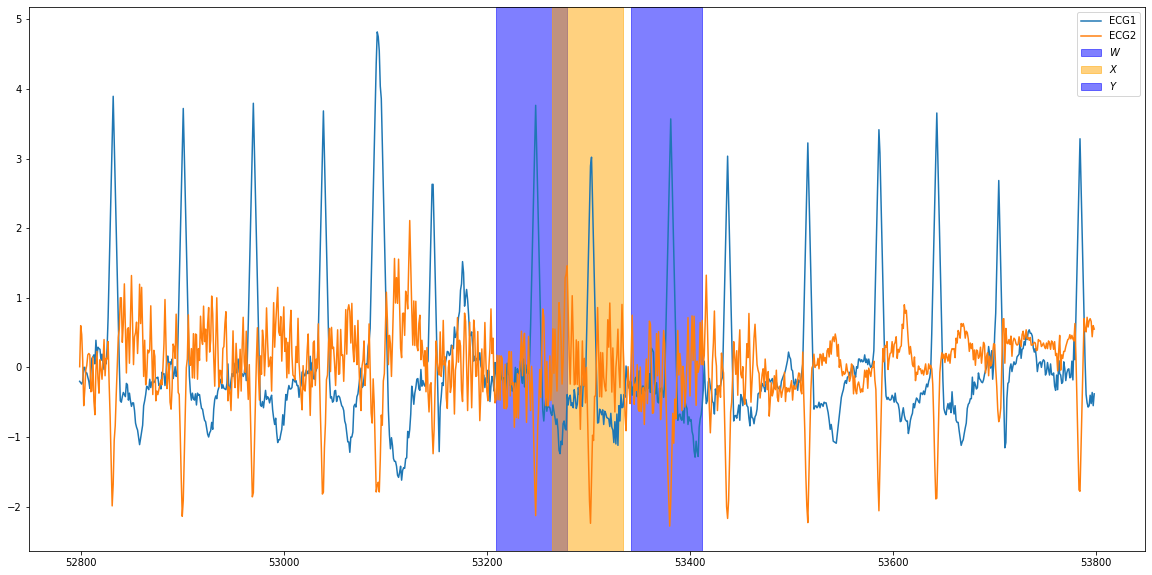

In [22]:
def plot_window(pos, color="blue", **kvs):
    start = pos - beat_window_margin
    end = pos + beat_window_margin
    plt.axvspan(start, end, color=color, alpha=0.5, **kvs)


index = 798

beat_n = df_beat.loc[index, "position"]
print("Selected beat is annotated as", df_beat.loc[index, "label"])
print("with timestamp", df_record.loc[beat_n, "timestamp"])
ax = df_record.iloc[beat_n-500:beat_n+500].plot(kind='line', y=['ECG1', 'ECG2'], use_index=True, figsize=(20,10))
plot_window(df_beat.loc[index-1, "position"], label="$W$")
plot_window(beat_n, color="orange", label="$X$")
plot_window(df_beat.loc[index+1, "position"], label="$Y$")
plt.legend()
plt.show()

#### Windows for external anomalies

In [23]:
df_pipe = df_beat.copy()
df_pipe = df_pipe[(df_pipe["label"] == "|") | (df_pipe["label"] == "Q")]
df_pipe["window_start"] = df_pipe["position"]-beat_window_margin
df_pipe["window_end"] = df_pipe["position"]+beat_window_margin
df_pipe = df_pipe[["position", "window_start", "window_end"]]
df_pipe.head()

,position,window_start,window_end
324,22183,22148,22218
373,25336,25301,25371
461,30945,30910,30980
706,47098,47063,47133
787,52542,52507,52577


#### Windows for anomalous beats

In [25]:
df_tmp = df_beat.copy()
df_tmp = df_tmp[(df_tmp["label"] != "|") & (df_tmp["label"] != "~") & (df_tmp["label"] != "+")]
df_tmp["position_next"] = df_tmp["position"].shift(-1)
df_tmp["position_prev"] = df_tmp["position"].shift(1)
#df_tmp = df_tmp[(df_tmp["position_prev"].notnull()) & (df_tmp["position_next"].notnull())]
df_tmp = df_tmp[(df_tmp["label"] != "Q") & (df_tmp["label"] != "N")]
df_tmp["window_start"] = np.minimum(df_tmp["position"].values-beat_window_margin, df_tmp["position_prev"].values+beat_window_margin)
df_tmp["window_end"] = np.maximum(df_tmp["position"].values+beat_window_margin, df_tmp["position_next"].values-beat_window_margin)
df_svf = df_tmp[["position", "window_start", "window_end"]]
df_tmp.groupby("label").count()

,position,position_next,position_prev,window_start,window_end
label,,,,,
B,1,1,1,1,1
S,227,227,227,227,227
V,555,555,555,555,555


#### Merge everything together

In [26]:
df_windows = pd.concat([df_pipe, df_svf])
df_windows.head()

,position,window_start,window_end
324,22183,22148.0,22218.0
373,25336,25301.0,25371.0
461,30945,30910.0,30980.0
706,47098,47063.0,47133.0
787,52542,52507.0,52577.0


Selected beat is annotated as S
with timestamp 1970-01-01 00:06:56.398437500


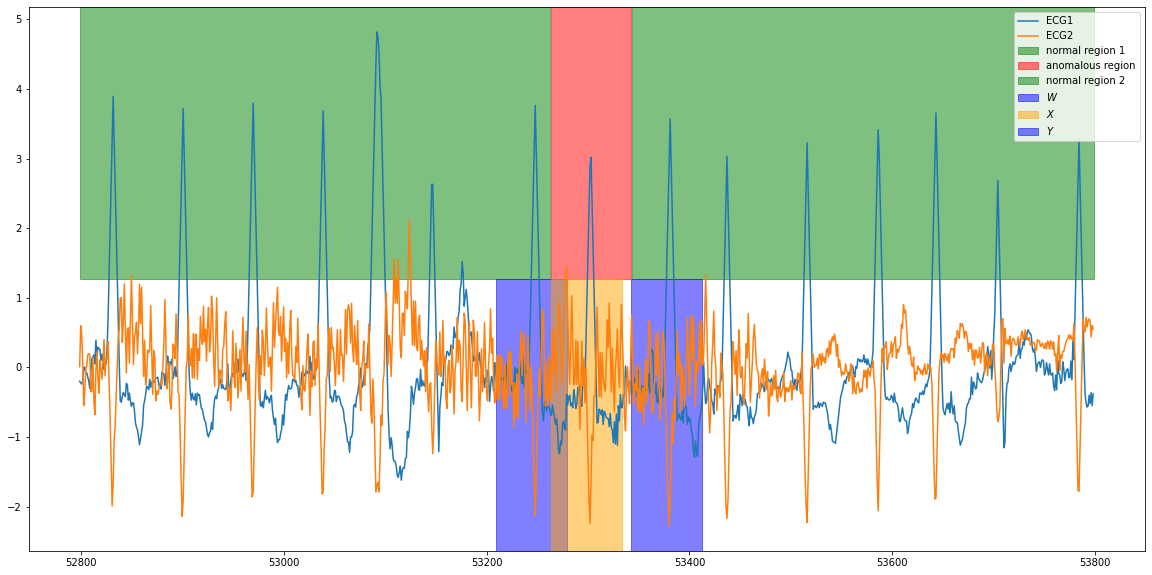

In [27]:
index = 798

beat = df_windows.loc[index, "position"]
start = df_windows.loc[index, "window_start"]
end = df_windows.loc[index, "window_end"]
print("Selected beat is annotated as", df_beat.loc[index, "label"])
print("with timestamp", df_record.loc[beat, "timestamp"])
ax = df_record.iloc[beat-500:beat+500].plot(kind='line', y=['ECG1', 'ECG2'], use_index=True, figsize=(20,10))
plt.axvspan(beat-500, start-1, color="green", alpha=0.5, label="normal region 1", ymin=.5)
plt.axvspan(start, end, color="red", alpha=0.5, label="anomalous region", ymin=.5)
plt.axvspan(end+1, beat+500, color="green", alpha=0.5, label="normal region 2", ymin=.5)
plot_window(df_beat.loc[index-1, "position"], label="$W$", ymax=.5)
plot_window(beat_n, color="orange", label="$X$", ymax=.5)
plot_window(df_beat.loc[index+1, "position"], label="$Y$", ymax=.5)
plt.legend()
plt.show()

### Add labels

In [28]:
df = df_record.copy()
df["is_anomaly"] = 0

for _, (_, t1, t2) in df_windows.iterrows():
    tmp = df[df.index >= t1]
    tmp = tmp[tmp.index <= t2]
    df["is_anomaly"].values[tmp.index] = 1

#df = df.set_index("timestamp")
df[df["is_anomaly"] == 1]

,ECG1,ECG2,timestamp,is_anomaly
1042,-1.29,0.48,1970-01-01 00:00:08.140625000,1
1043,-1.36,0.49,1970-01-01 00:00:08.148437500,1
1044,-1.40,0.61,1970-01-01 00:00:08.156250000,1
1045,-1.41,0.54,1970-01-01 00:00:08.164062500,1
1046,-1.29,0.53,1970-01-01 00:00:08.171875000,1
...,...,...,...,...
230335,0.00,-0.08,1970-01-01 00:29:59.492187500,1
230336,0.02,-0.06,1970-01-01 00:29:59.500000000,1
230337,0.01,-0.09,1970-01-01 00:29:59.507812500,1
230338,-0.06,-0.07,1970-01-01 00:29:59.515625000,1


In [29]:
df_beat[(df_beat["label"] == "|")]

,position,label
324,22183,|
461,30945,|
706,47098,|
787,52542,|
2339,156431,|
2815,186982,|


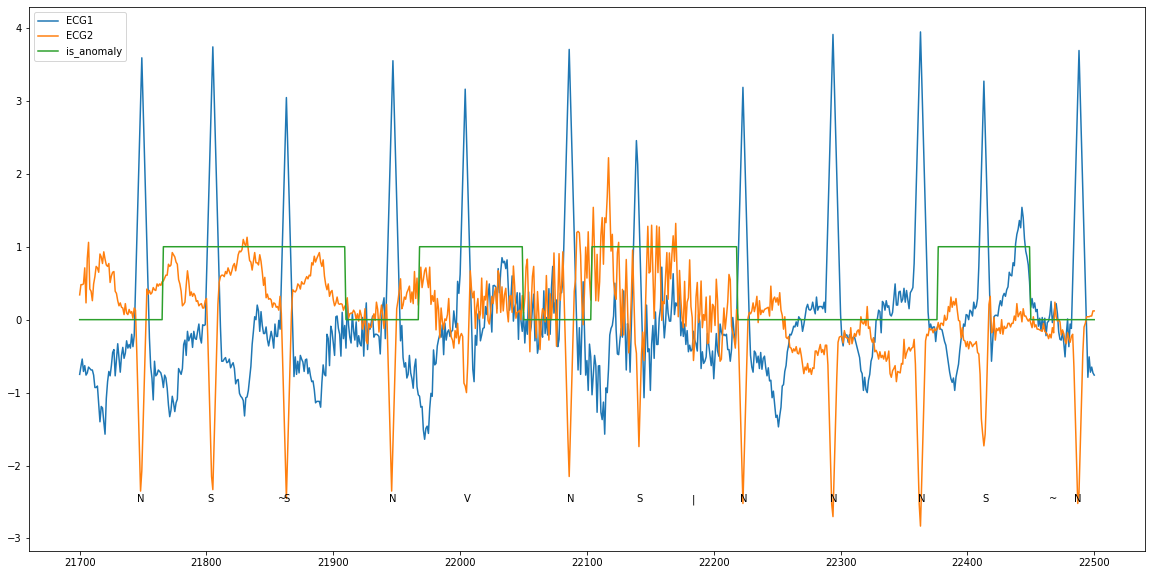

In [30]:
start = 21700
end = 22500
df_show = df.loc[start:end]
df_show.plot(kind='line', y=['ECG1', 'ECG2', 'is_anomaly'], use_index=True, figsize=(20,10))

labels = df_beat[(df_beat["position"] > start) & (df_beat["position"] < end)]
for i, (position, label) in labels.iterrows():
    plt.text(position, -2.5, label)
plt.show()

## Experimentation

In [17]:
df = pd.merge(df_record, df_annotation, left_index=True, right_index=True, how="outer")
#df = df.fillna(value={"Label": ".", "is_anomaly": 0})
df.groupby(["is_anomaly"]).count()

,ECG1,ECG2,timestamp,Label
is_anomaly,,,,
0.0,1846,1846,1846,1846
1.0,75,75,75,75


In [18]:
df[df["Label"].notna()]

,ECG1,ECG2,timestamp,Label,is_anomaly
162,0.705,-0.015,1970-01-01 00:00:01.265625000,N,0.0
330,0.355,-0.025,1970-01-01 00:00:02.578125000,N,0.0
497,0.335,-0.075,1970-01-01 00:00:03.882812500,N,0.0
666,0.295,-0.025,1970-01-01 00:00:05.203125000,N,0.0
836,0.485,-0.015,1970-01-01 00:00:06.531250000,N,0.0
...,...,...,...,...,...
229735,0.575,-0.055,1970-01-01 00:29:54.804687500,N,0.0
229874,0.405,-0.005,1970-01-01 00:29:55.890625000,N,0.0
230014,0.485,-0.065,1970-01-01 00:29:56.984375000,N,0.0
230153,0.275,-0.075,1970-01-01 00:29:58.070312500,N,0.0


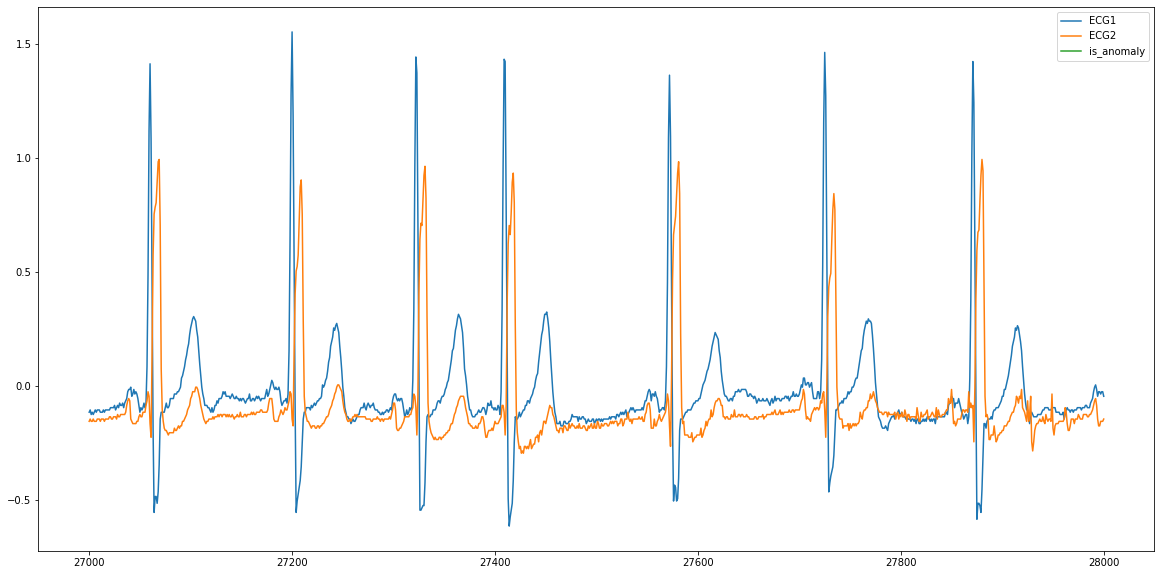

In [19]:
import matplotlib.pyplot as plt
df_show = df.loc[27000:28000]
df_show.plot(kind='line', y=['ECG1', 'ECG2', 'is_anomaly'], use_index=True, figsize=(20,10))
plt.show()

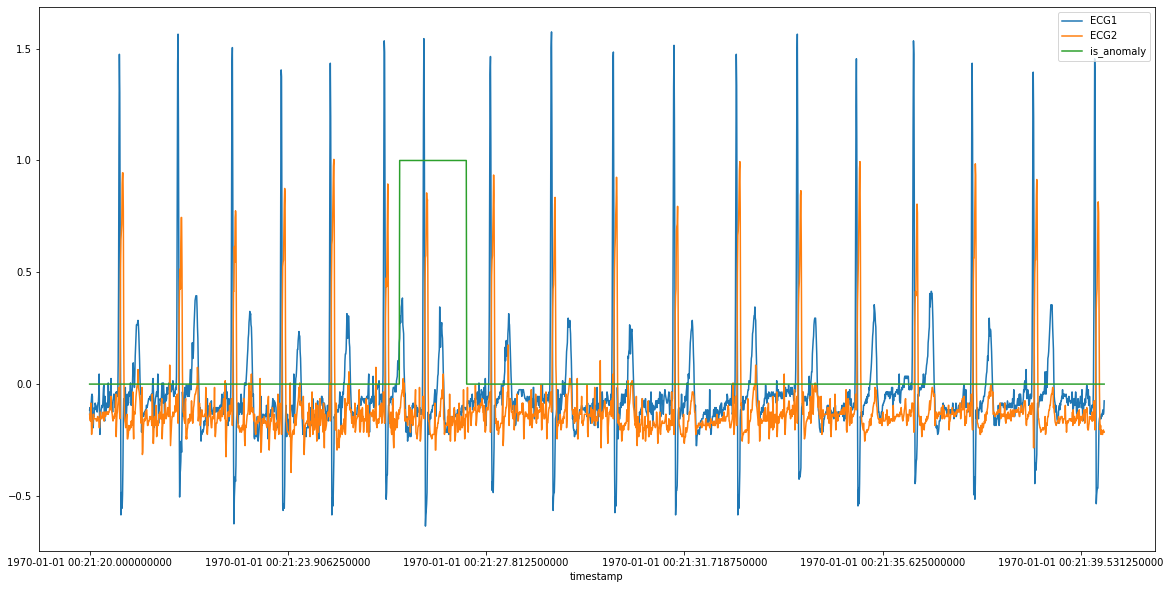

In [91]:
df = pd.read_csv(os.path.join(dataset_subfolder, "800.test.csv"), index_col="timestamp")
df.loc["1970-01-01 00:21:20":"1970-01-01 00:21:40"].plot(figsize=(20,10))
plt.show()